# Time Series Prediction

Neste notebook exploraremos e resolveremos o desafio do HackerRank de [Predição de CTR]( https://www.hackerrank.com/challenges/time-series-prediction/problem). Para isso, vamos explorar os conceitos e aplicações de algumas técnicas de séries temporais. 

## Estrutura do dataset

O dataset de treino e de teste tem uma composição bem parecida. O de treino contém na primeira linha o número de exemplos existentes nas linhas seguintes, já o de teste contém apenas os exemplos. Cada exemplo no arquivo de treino contém o número de seções de usuários em um dia e estes são contados consecutivamente a partir do dia 1 de outubro de 2012. Ambos os arquivos estão no formato `.txt`. 

## Definição do problema

O desafio proposto é prever o número de sessões de usuários nos próximos 30 dias a partir de um histórico de treino. 

In [9]:
from __future__ import division

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import lag_plot

BASE_DATA_PATH="data/"
TRAIN_FILENAME = "input01.txt"
TEST_FILENAME = "output01.txt"
BASE_DATE = datetime(2012, 10, 1)
# N_CONSECUTIVE_DAYS = 1133


def read_data_from_txt(filepath, base_date, skiprows=None, gen_index=False):
    d = pd.read_table(filepath, skiprows=0)
    
    if gen_index == True:
        indexes = [BASE_DATE + timedelta(days=x) for x in range(0, len(d))]
        ts = pd.Series(d.values.flatten(), index=indexes)
        return(ts)
    else:
        return(d)

## Explorando o dataset

Antes de explorar o dataset, é interessante citar que toda série temporal pode ser quebrada em três elementos principais, conforme a fórmula abaixo

$$
ts_{x} = s_{x} + t_{x} + d_{x}
$$

onde $s_{x}$ é um componente chamado sazonalidade (_seasonality_), $t_{x}$ é um componente chamado tendência (_trend_) e $d_{x}$ é um componente de resíduo, ou erro aleatório. Toda série temporal é uma combinação linear desses elementos. 

Observando a olho nu a série e, considerando a fórmula exposta acima, podemos dizer que não é possível identificar uma tendência clara na série (nem de crescimento e nem de decaimento). Já tem termos de sazonalidade, diria que existe um ciclo anual de comportamento. É possível perceber isso comparando os dois períodos de outubro a janeiro presentes no gráfico, mas o gráfico carece de mais pontos para confirmar essa avaliação de forma mais assertiva. 

Uma outra forma de averiguar isso é através do gráfico de decomposição de uma série temporal, que pode ser visto abaixo também. A partir dele podemos ver que o intervalo de dados que plotamos não tem um elemento de sazonalidade clara e nem de tendência. Esses fatores são importantes porque balizam a escolha da técnica de séries temporais que melhor se aplica a esse desafio. 

In [2]:
f = BASE_DATA_PATH+TRAIN_FILENAME
ts_train = read_data_from_txt(f, BASE_DATE, skiprows=0, gen_index=True)

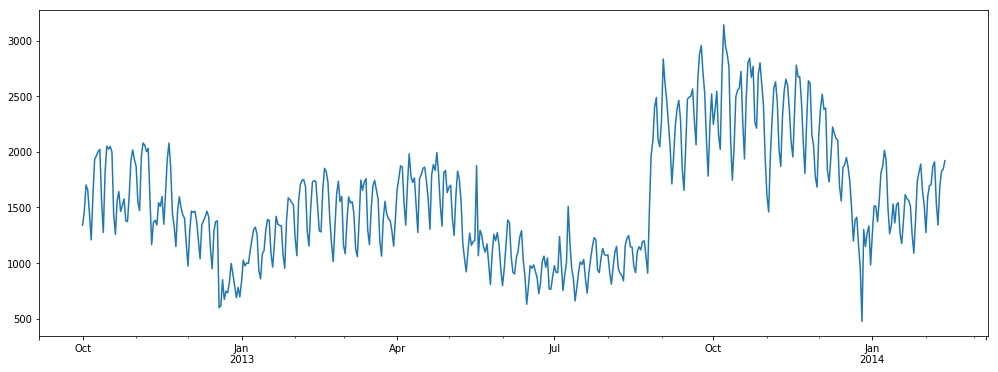

In [5]:
plt.figure(figsize=(17, 6))
ts_train.plot()
plt.show()

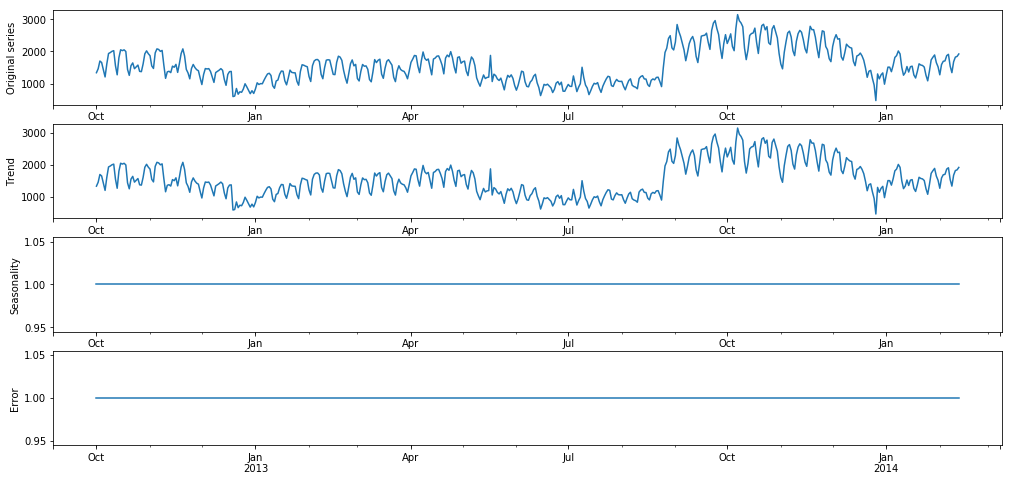

In [10]:
res = seasonal_decompose(ts_train, model='multiplicative', freq=1)
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(17,8))

ax1.set_ylabel("Original series")
res.observed.plot(ax=ax1)
ax2.set_ylabel("Trend")
res.trend.plot(ax=ax2)
ax3.set_ylabel("Seasonality")
res.seasonal.plot(ax=ax3)
ax4.set_ylabel("Error")
res.resid.plot(ax=ax4)
plt.show()

### Estacionaridade

Uma série estacionária é aquela que não possui nem componente de tendência e nem de sazonalidade. Ela também pode ser identificada pelo fato de ter média e variância constantes. Observando a olho nu a série temporal do desafio, ela aparenta ser estacionária, mas para confirmar essa hipótese, usaremos dois testes:

* Métricas estatísticas em diferentes pontos da série
* Augmented Dickey-Fuller test


#### Métricas estatísticas

Consiste em quebrar a série temporal em algumas partes e averiguar se a variância e a média são semelhantes nessas partes. Além disso, como estamos trabalhando com conceitos de média e variância, de certo modo estamos assumindo que os dados estão seguindo uma distribuição gaussiana. 

A partir do histograma abaixo, percebe-se que os dados não seguem ao certo uma distribuição normal, e tem um "viés"/cauda direita um pouco mais longa, o que já é um indicador de que a série não é estacionária. Logo depois, a partir da quebra em duas e três partes da série temporal, percebemos que os valores das métricas estatísticas divergem bastante em cada uma das sub-séries, o que é um indicativo de que a série não é estacionária.

Para tirar toda e qualquer dúvida sobre a estacionaridade da série, usaremos um teste mais formal para bater o martelo sobre isso.

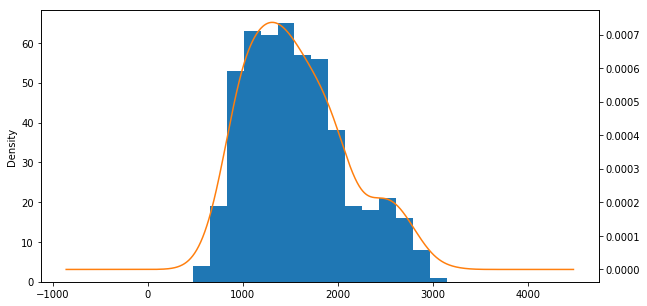

In [7]:
plt.figure(figsize=(10,5))
ts_train.hist(bins=15)
ts_train.plot.kde(secondary_y=True)
plt.show()

In [31]:
series_array = ts_train.values.flatten()

split_2_size = int(len(series_array)/2)
split_3_size = int(len(series_array)/3)

s1, s2 = series_array[:split_2_size], series_array[split_2_size:]
m1, m2 = s1.mean(), s2.mean()
var1, var2 = s1.var(), s2.var()

print("Splitting time series in 2 parts")
print("--------------------------------------")
print("mean1 = {:.2f} and mean2 = {:.2f}".format(m1, m2))
print("variance1 = {:.2f} and variance2 = {:.2f}".format(var1, var2))
print("--------------------------------------")

s1, s2, s3 = series_array[:split_3_size], series_array[split_3_size:split_3_size*2], \
                        series_array[(split_3_size*2):]
m1, m2, m3 = s1.mean(), s2.mean(), s3.mean()
var1, var2, var3 = s1.var(), s2.var(), s3.var()

print("\n\nSplitting time series in 3 parts")
print("--------------------------------------")
print("mean1 = {:.2f} and mean2 = {:.2f} and mean3 = {:.2f}".format(m1, m2, m3))
print("variance1 = {:.2f} and variance2 = {:.2f} and variance3 = {:.2f}".format(var1, var2, var3))
print("--------------------------------------")

Splitting time series in 2 parts
--------------------------------------
mean1 = 1420.23 and mean2 = 1705.89
variance1 = 111327.20 and variance2 = 412778.38
--------------------------------------


Splitting time series in 3 parts
--------------------------------------
mean1 = 1411.21 and mean2 = 1243.43 and mean3 = 2028.92
variance1 = 118489.06 and variance2 = 124854.56 and variance3 = 259433.17
--------------------------------------


#### Augmented Dickey-Fuller test

É um teste estatístico de hipótese de raiz unitária que visa identificar se a série é estacionária ou não. Para isso, considera as duas seguintes hipóteses:

* **Hipótese nula**: existe uma raiz unitária, portanto a série não é estacionária
* **Hipótese alternativa**: a série é estacionária 

É possível ter maiores detalhes sobre esse teste [neste vídeo](https://www.youtube.com/watch?v=X8nGZ2UCJsk) e [neste texto também](http://dacatay.com/data-science/part-3-time-series-stationarity-python/). De modo geral, se após a realização do teste obtivermos um p-value menor do que 5% podemos descartar a hipótese nula. Outra forma de interpretar o resultado do teste é comparando o resultado da distribuição $DF_{t}$ (uma distribuição t) calculada com os valores críticos tabelados. Se $DF_{t}$ calculado é mais negativo que o valor da tabela então rejeita-se a hipótese nula. 

O código abaixo mostra a implementação desse teste. Como resultados, tivemos que o p-value é de 34%, portanto aceitamos a hipótese nula e temos que a série original não é estacionária. 

<span style='color:red'>Aplicando dois níveis de diferenciação na série é possível obter uma série estacionária. Dá pra perceber isso repetindo o processo de diferenciação + aplicação do ADF test</span>

In [7]:
series_array = ts_train.values.flatten()

test_results = adfuller(series_array)

print('test statistic: {}'.format(test_results[0]))
print('p-value: {}'.format(test_results[1]))
print('Critical Values:')
for key, value in test_results[4].items():
    print('\t{}: {:.3f}'.format(key, value))


test statistic: -1.87461621136
p-value: 0.34409503006
Critical Values:
	5%: -2.868
	1%: -3.444
	10%: -2.570


## Modelagem

Escolha do modelo pode ter algumas tips a partir de lag_plot (indicativo de modelo auto regressivo), checar outliers (indica moving average)

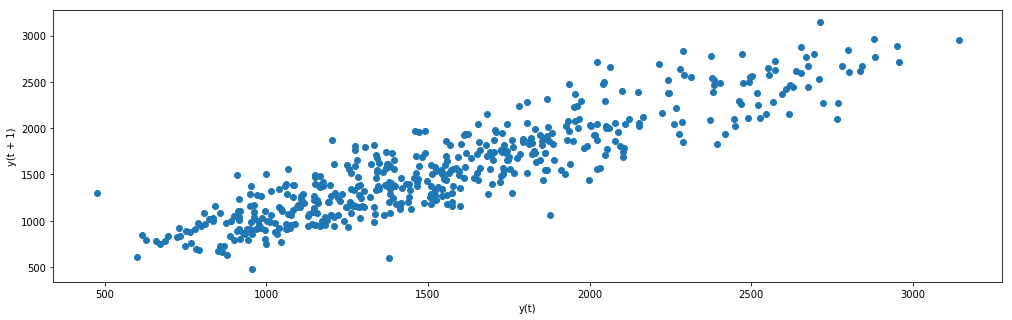

In [12]:
plt.figure(figsize=(17,5))
lag_plot(ts_train)
plt.show()

## Referências

1. https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
2. https://otexts.org/fpp2/stl.html
3. https://machinelearningmastery.com/time-series-data-stationary-python/
4. https://github.com/2wavetech/How-to-Check-if-Time-Series-Data-is-Stationary-with-Python
5. https://people.maths.bris.ac.uk/~magpn/Research/LSTS/TOS.html
6. http://www.statosphere.com.au/check-time-series-stationary-r/
7. https://dsp.stackexchange.com/questions/481/does-the-autocorrelation-function-completely-describe-a-stochastic-process/488#488
8. http://www.statisticshowto.com/lag-plot/
